In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error, mean_absolute_error

from src.visualizations import *
from src.modelling import *

In [2]:
# parse dates, so that pandas reads dates as date type, not string
df = pd.read_excel('forecasting_take_home_data_v2.xlsx', parse_dates=True)

In [3]:
df.head()

,Month,"Regular Motor Gasoline, Conventional Gasoline Areas, Retail Price ($/Gallon incl. Taxes)"
0,1992-01-01,1.022
1,1992-02-01,1.006
2,1992-03-01,1.013
3,1992-04-01,1.052
4,1992-05-01,1.107


In [4]:
df.describe()

,"Regular Motor Gasoline, Conventional Gasoline Areas, Retail Price ($/Gallon incl. Taxes)"
count,313.000000
mean,2.026236
std,0.893544
min,0.900000
25%,1.188000
50%,1.863000
75%,2.700000
max,4.002000


Based off of some prelim EDA, there are no 0 or null values in the dataset.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 313 entries, 0 to 312
Data columns (total 2 columns):
 #   Column                                                                                    Non-Null Count  Dtype         
---  ------                                                                                    --------------  -----         
 0   Month                                                                                     313 non-null    datetime64[ns]
 1   Regular Motor Gasoline, Conventional Gasoline Areas, Retail Price ($/Gallon incl. Taxes)  313 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.0 KB


The dataset contains 27 years with 1992 being the earliest and 2018 the latest. 

However, Janualy 2018 is the only month included in 2018.

In [6]:
years = df.Month.dt.year.unique()

print(sorted(years), '\n')
print(len(years))

[1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018] 

27


In [7]:
df[df.Month.dt.year == 2018]

,Month,"Regular Motor Gasoline, Conventional Gasoline Areas, Retail Price ($/Gallon incl. Taxes)"
312,2018-01-01,2.467


Columns must be renamed in order to be used by FB Prophet.

In [8]:
# rename columns, so that these columns can be consumed by prophet model
df.rename(columns={'Month': 'ds', 'Regular Motor Gasoline, Conventional Gasoline Areas, Retail Price ($/Gallon incl. Taxes)': 'y'}, inplace=True)

Group by year to calculate the average gasoline price per year.

In [9]:
yearly_price_groups = df.groupby(df.ds.dt.year).mean()['y'].reset_index()
yearly_price_groups.head()

,ds,y
0,1992,1.085750
1,1993,1.067083
2,1994,1.071333
3,1995,1.102250
4,1996,1.192250


Looking at the general trend of gasoline prices over the years, there were significant declines in prices from 2008-2009 and from 2014-2016.

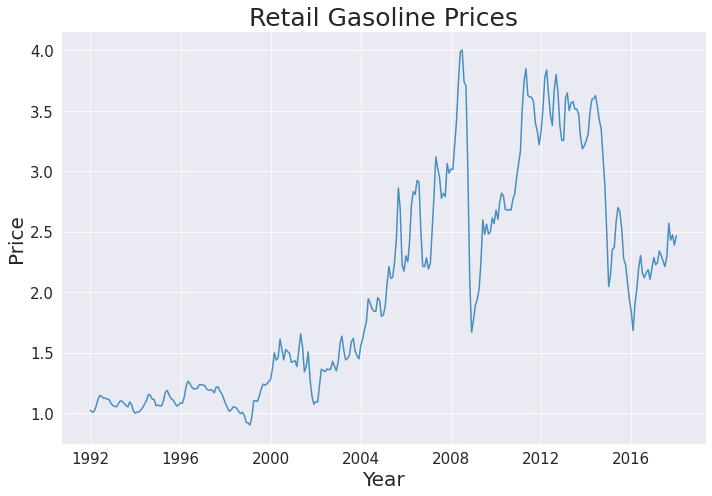

In [10]:
fig, ax = plt.subplots(figsize=(10,7))

plot_line(df['ds'], df['y'], 'Retail Gasoline Prices', 'Year', 'Price', ax)
# plt.savefig('retail_gas_prices.png')

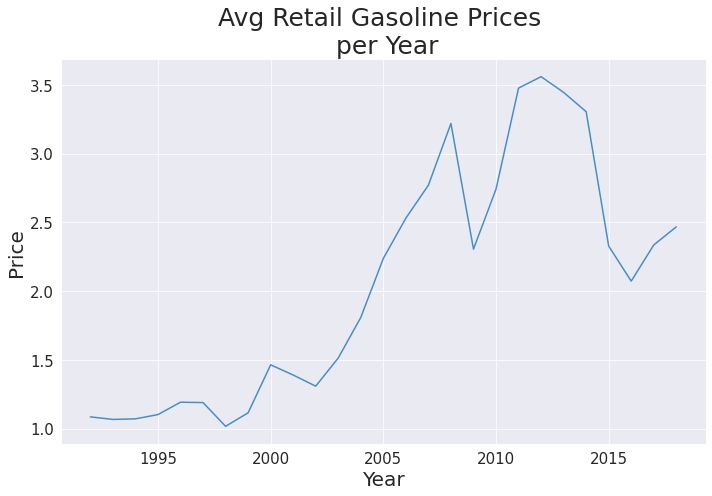

In [11]:
fig, ax = plt.subplots(figsize=(10,7))

plot_line(yearly_price_groups['ds'], yearly_price_groups['y'], 
          'Avg Retail Gasoline Prices \n per Year', 'Year', 'Price', ax)
# plt.savefig('avg_retail_gas_prices.png')

Interested to see if there are any monthly trends over the last 10 years since the 2008 Global Financial Crisis, including the Great Oil & Gas Crash of 2014.

Based off of the graph below, there doesn't appear to be any monthly seasonality for gasoline prices.

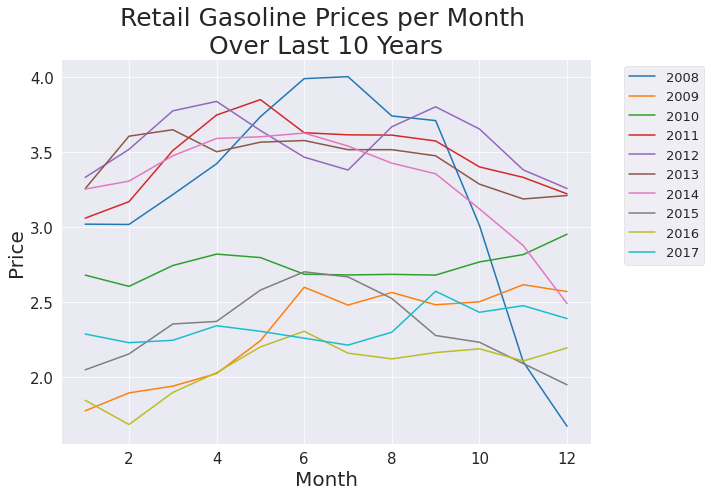

In [12]:
# create temp table to exract month and yr from df 
last_10_years = years[-11: -1]

temp = df[df.ds.dt.year.isin(last_10_years)].copy()
temp['month'] = temp.ds.dt.month
temp['year'] = temp.ds.dt.year
temp_groups = temp.groupby('year')

# plot gas prices over last 10 yrs
fig, ax = plt.subplots(figsize=(10,7))

plot_mult_lines_groupby(temp_groups, 
                        'Retail Gasoline Prices per Month \nOver Last 10 Years', 
                        'Month', 'Price', ax)
# plt.savefig('gas_prices_last_10_yrs.png')

## Train/Test Split

Split data into train/test sets, keep last full year as test set.

In [13]:
# split data into train/test sets
split_date = '2017-01-01'
train = df.loc[df.ds <= split_date].copy()
test = df.loc[df.ds > split_date].copy()

## Base Model

In [14]:
prophet, test_forecast = make_base_model(train, test)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Root mean squared error (RMSE), instead of Mean Absolute Error, is a more appropriate metric to evaluate this time series model as RMSE penalizes outliers/larger errors.

The RMSE for the base model is 0.21.

In [15]:
rmse = np.sqrt(mean_squared_error(test['y'], test_forecast['yhat']))
rmse

0.21089673506058532

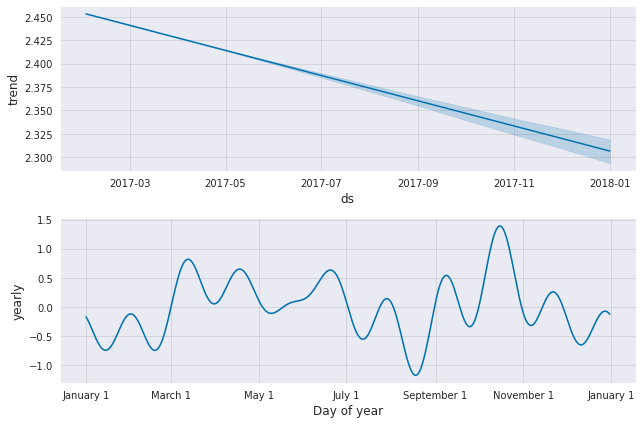

In [16]:
fig = prophet.plot_components(test_forecast)

# plt.savefig('test_set_components_base.png')

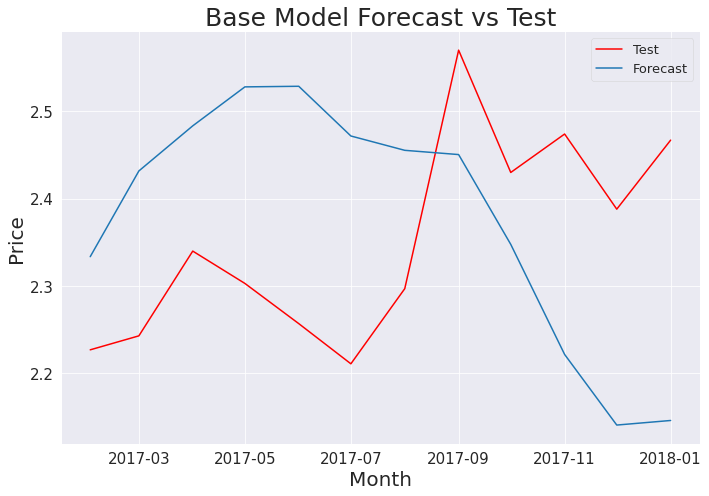

In [17]:
fig, ax = plt.subplots(figsize=(10,7))

compare_test_forecast(test['ds'], test['y'], test_forecast['ds'], 
                      test_forecast['yhat'], 'Base Model Forecast vs Test', ax)
# plt.savefig('base_compare_fcst_test.png')

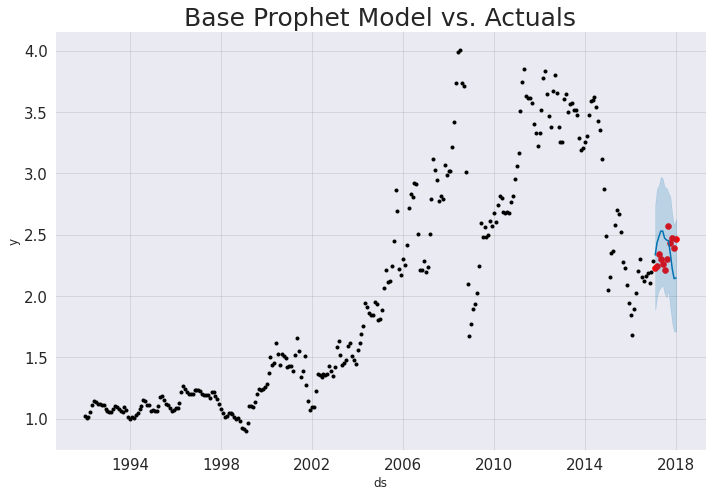

In [18]:
fig, ax = plt.subplots(figsize=(10,7))
ax.scatter(test['ds'], test['y'], color='red')
plt.title('Base Prophet Model vs. Actuals', fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()

fig = prophet.plot(test_forecast, uncertainty=True, ax=ax)
# plt.savefig('base_prophet_model_vs_actuals.png')

## Additional Regressors

Additional regressors can be added to take into account special events/phenomena that happened historically.

Regressors were added to take into account the 2008 Financial Crisis and Great Oil and Gas Crash of 2014, which dramatically affected gasoline prices.

In [19]:
# include additional regressors in df
df['during_world_fin_crisis'] = 0
df['during_oil_gas_crash'] = 0

df.loc[(df['ds'] >= '2008-01-01') & (df['ds'] < '2010-01-01'), 'during_world_fin_crisis'] = 1
df.loc[(df['ds'] >= '2014-01-01') & (df['ds'] < '2016-01-01'), 'during_oil_gas_crash'] = 1

In [20]:
# split data into train/test sets
split_date = '2017-01-01'
train = df.loc[df.ds <= split_date].copy()
test = df.loc[df.ds > split_date].copy()

In [21]:
prophet, test_forecast2 = make_model_wth_regressors(train, test)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Model improved, RMSE decreased by 29%.

In [22]:
rmse = np.sqrt(mean_squared_error(test['y'], test_forecast2['yhat']))
rmse

0.1480472203698438

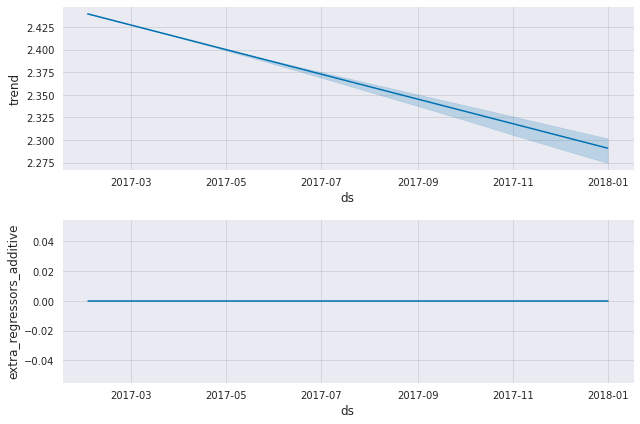

In [23]:
fig = prophet.plot_components(test_forecast2)

# plt.savefig('test_set_components_reg.png')

The model also does a better job of generalizing the test set.

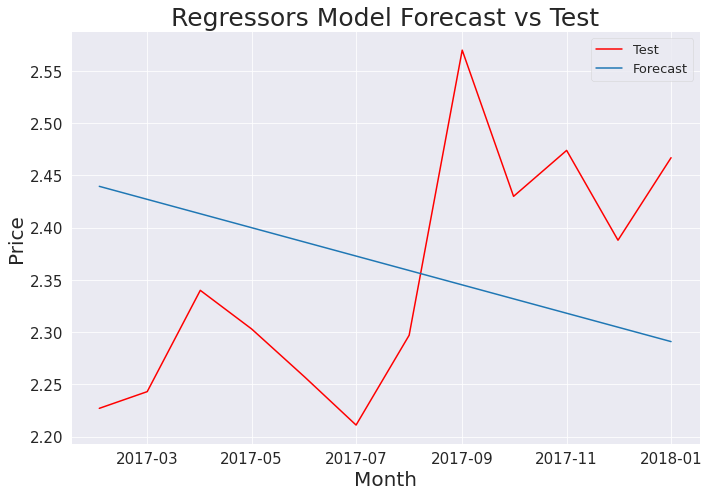

In [24]:
fig, ax = plt.subplots(figsize=(10,7))

compare_test_forecast(test['ds'], test['y'], 
                      test_forecast2['ds'], 
                      test_forecast2['yhat'], 
                      'Regressors Model Forecast vs Test', 
                      ax)
# plt.savefig('reg_compare_fcst_test.png')

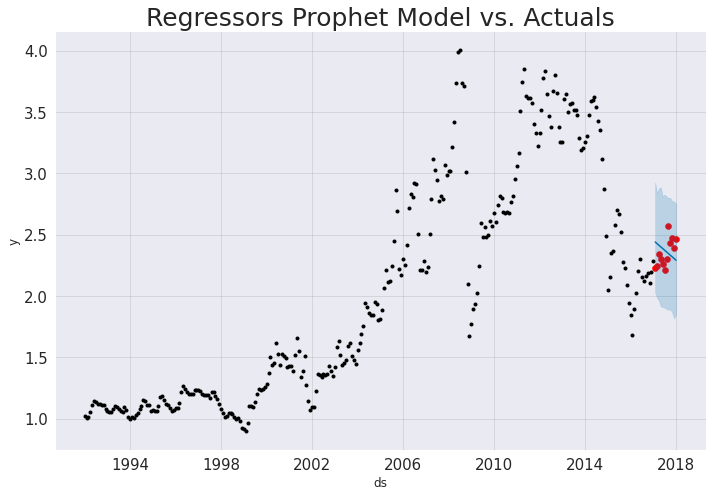

In [25]:
fig, ax = plt.subplots(figsize=(10,7))
ax.scatter(test['ds'], test['y'], color='red')
plt.title('Regressors Prophet Model vs. Actuals', fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()

fig = prophet.plot(test_forecast2, uncertainty=True, ax=ax)

# plt.savefig('reg_prophet_model_vs_actuals.png')